In [38]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as T
from mpl_toolkits.mplot3d import Axes3D


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0.5,0.92,'Uniform prior landscape; alterate view')

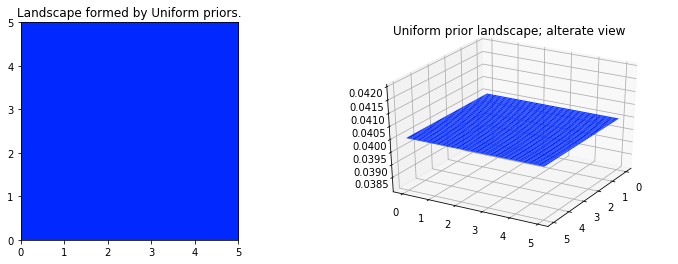

In [39]:
figsize(12.5, 4)

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
              cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Landscape formed by Uniform priors.')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title('Uniform prior landscape; alterate view')

Text(0.5,0.92,'$Exp(3), Exp(10)$ prior landscape; \nalternate view')

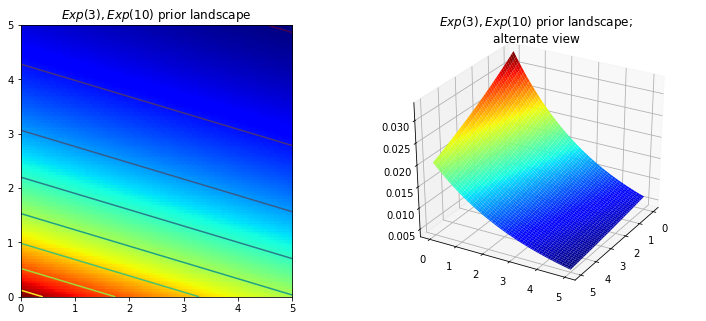

In [40]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
               cmap=jet, extent=(0, 5, 0, 5))

plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")

In [41]:
N = 1

lambda_1_true = 1
lambda_2_true = 3

data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))   
], axis=1)
print('observed (2-dimensional, sample size = %d):' % N, data)

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 0], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional, sample size = 1): [[1 5]]


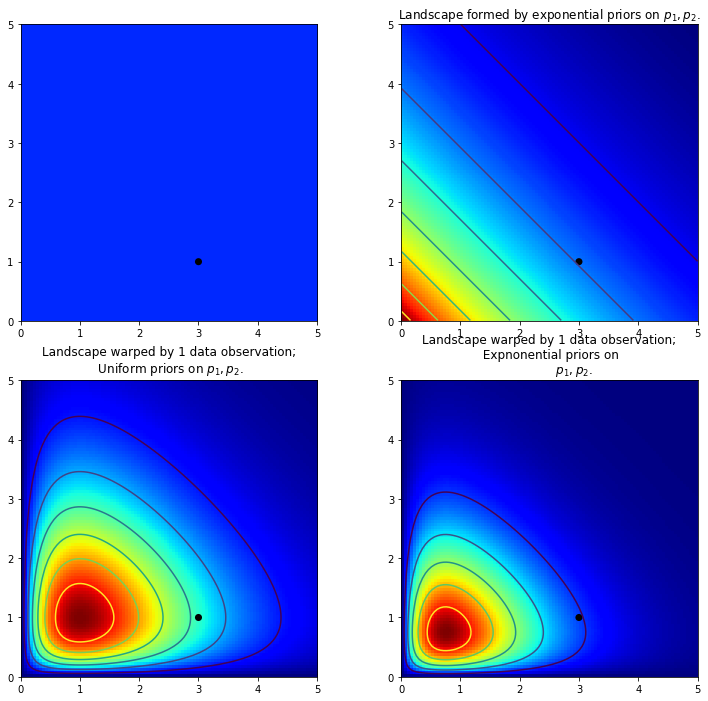

In [42]:
figsize(12.5, 12)

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
               cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
plt.xlim(0, 5)
plt.ylim(0, 5)


plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
               cmap=jet, extent=(0, 5, 0, 5))

plt.title('Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$.' % N)
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')

plt.xlim(0, 5)
plt.ylim(0, 5)


plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(y, loc=0, scale=3)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
               cmap=jet, extent=(0, 5, 0, 5))

plt.title('Landscape formed by exponential priors on $p_1, p_2$.')
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')

plt.xlim(0, 5)
plt.ylim(0, 5)


plt.subplot(224)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
               cmap=jet, extent=(0, 5, 0, 5))

plt.title("""Landscape warped by %d data observation;\n Expnonential priors on
             $p_1, p_2$.""" % N)
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')    

plt.xlim(0, 5)
plt.ylim(0, 5);

In [43]:
figsize(12.5, 4)

In [44]:
# need to find this dataset
data = np.loadtxt('data/mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=.8)
plt.title('Histogram of the dataset')
plt.ylim([0, None])
print(data[:10], '...')

OSError: data/mixture_data.csv not found.

In [45]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical('assignment', p,
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
print('prior assignment, with p = %.2f:' % p1.tag.test_value)
print(assignment.tag.test_value[:10])
    
    

prior assignment, with p = 0.50:
[0]


In [46]:
with model:
    sds = pm.Uniform('sds', 0, 100, shape=2)
    centers = pm.Normal('centers',
                       mu=np.array([120, 190]),
                       sd=np.array([10, 10]),
                       shape=2)
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and combineit with the observations
    observations = pm.Normal('obs', mu=center_i, sd=sd_i, observed=data)
    
print('Random assignments: ', assignment.tag.test_value[:4], '...')
print('Assigned center: ', center_i.tag.test_value[:4], '...')
print('Assigned standard deviation: ', sd_i.tag.test_value[:4], '...')



Random assignments:  [0] ...
Assigned center:  [120.] ...
Assigned standard deviation:  [50.] ...


In [47]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])
    

TypeError: The broadcastable pattern of the input is incorrect for this op. Expected (True,), got (False,).

NameError: name 'trace' is not defined

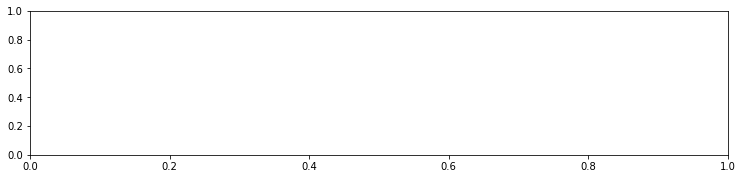

In [48]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace =trace['centers']

colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
    
plt.plot(center_trace[:, 0], label='trace of center 0', c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label='trace of center 1', c=colors[1], lw=lw)
plt.title('Traces of unknown parameters')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace['sds']
plt.plot(std_trace[:, 0], label='trace of standard deviation of cluster 0', c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label='trace of standard deviation of cluster 1', c=colors[1], lw=lw)
plt.legend(loc='upper left')

plt.subplot(313)
p_trace =trace['p']
plt.plot(p_trace, label='$p$: frequency of assignment to cluster 0', c=colors[0], lw=lw)
plt.xlabel('Steps')
plt.ylim(0, 1)
plt.legend();

In [49]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

NameError: name 'step1' is not defined

In [50]:
figsize(12.5, 4)
center_trace = trace['centers'][25000:]
prev_center_trace = trace['centers'][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label='previous trace of center 0',
        lw=lw, alpha=.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label='previous trace of center 1',
        lw=lw, alpha=.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label='new trace of center 0',
        lw=lw, c=colors[0])
plt.plot(x, center_trace[:, 1], label='new trace of center 1',
        lw=lw, c=colors[1])
plt.title('Traces of unknown center parameters')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(.8)
plt.xlabel('Steps');


NameError: name 'trace' is not defined

In [51]:
# investigate clusters
figsize(11, 4)
std_trace = trace['sds'][25000:]
prev_std_trace = trace['sds'][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title('Posterior of center of cluster %d' % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
            histtype='stepfilled')

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title('Posterior of stwandard deviation of cluster %d' % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
            histtype='stepfilled')
plt.tight_layout()

NameError: name 'trace' is not defined